In [36]:
import torch
import torch.nn as nn 
import pandas as pd
import numpy as np
import time
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import datetime
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

In [37]:
from src.algorithms.TanoGan import TanoGan
from src.utils.util import *
from src.dataset.wadi import WadiDataset
from src.model.modelTanoGan import *
from src.utils.timeseries_anomalies import _fixed_threshold,_find_threshold

In [38]:
#This is the beginning of programm
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print(current_time)
    


04:48:02


<h4>Initializing Dataset</h4>

In [39]:
class ArgsTrn:
    workers=4
    batch_size=32
    epochs=1
    lr=0.0002
    cuda = True
    manualSeed=2
    mean=0
    std=0.1
    
opt_trn=ArgsTrn()
torch.manual_seed(opt_trn.manualSeed)


class Datasettings:
    
    def __init__(self):
        self.dataset_training_name="/home/jupyter/GRANOGAN-IISC/data/wadi/WADI_14days.csv"
        self.dataset_test_name="/home/jupyter/GRANOGAN-IISC/data/wadi/WADI_attackdata.csv"
        self.dataset_anomaly_name="/home/jupyter/GRANOGAN-IISC/data/wadi/WADI_anomalies.csv"
        self.train=True
        self.window_length=60

In [41]:
seed=0
data_settings = Datasettings()
wadi = WadiDataset(seed,data_settings)

In [42]:
x_train, y_train, x_test, y_test = wadi.data()

(1209601, 126)
Total Number of anomalies in train set = 0
Total Number of anomalies in test set = 9948
% of anomalies in the test set = 5.7569111289865225
number of anomalous events = 14


In [43]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(x_train)
x_train = imputer.transform(x_train)

In [44]:
reduced_dimesnion=3
pca = PCA(n_components=reduced_dimesnion, svd_solver='full')
pca.fit(x_train)
x_train=pca.transform(x_train)

In [45]:
pca = PCA(n_components=reduced_dimesnion, svd_solver='full')
pca.fit(x_test)
x_test=pca.transform(x_test)

In [46]:
sequences,y_train_per_window = get_sub_seqs(x_train,y_train, seq_len=60, stride=1,
                                 start_discont=np.array([]))

In [30]:
train_loader, train_val_loader = get_train_data_loaders(sequences, batch_size=32,
                                                                splits=[1 - 0.2,
                                                                        0.2], seed=0)

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seq_len = wadi.window_length # sequence length is equal to the window length
in_dim = reduced_dimesnion # input dimension is same as number of feature
n_features=reduced_dimesnion

In [48]:
embedding_dim=16
tanoGan=TanoGan(device=device,opt_trn=opt_trn,windows_length=seq_len,n_features=n_features,embedding_dim=embedding_dim)

In [33]:
trained_D,trained_G=tanoGan.train_TanoGAN(train_loader)

/home/jupyter/src/algorithms/TanoGan.py:72: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,self.in_dim),mean=0,std=0.1)).to(self.device)
/home/jupyter/src/algorithms/TanoGan.py:88: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,self.in_dim),mean=0,std=0.1)).to(self.device)


KeyboardInterrupt: 

In [49]:
PATH_D='/home/jupyter/GRANOGAN-IISC/src/saved_models/tanogan/wadi/dicriminator.pkl'
PATH_G='/home/jupyter/GRANOGAN-IISC/src/saved_models/tanogan/wadi/generator.pkl'

In [ ]:
torch.save(trained_D.module.state_dict(), PATH_D)
torch.save(trained_G.module.state_dict(), PATH_G)

In [50]:
state_dict = torch.load(PATH_D)
trained_D=LSTMDiscriminator(in_dim=in_dim,device=device)
trained_D=nn.DataParallel(trained_D)
trained_D.to(device)
trained_D=tanoGan.load_model(state_dict,trained_D)

state_dict = torch.load(PATH_G)
trained_G=LSTMGenerator(in_dim=in_dim, out_dim=in_dim,device=device)
trained_G=nn.DataParallel(trained_G)
trained_G.to(device)
trained_G=tanoGan.load_model(state_dict,trained_G)

<h4>Loading back the saved models</h4>

In [51]:
tanoGan.intilialize_D(trained_D)
tanoGan.intilialize_G(trained_G)

<h2>Testing for anomaly</h2>


In [52]:
sequences,y_test_per_window = get_sub_seqs(x_test,y_test, seq_len=60, stride=60, start_discont=np.array([]))
test_loader = DataLoader(dataset=sequences, batch_size=1,  num_workers=4,
                                 shuffle=False)

In [ ]:
losses=tanoGan.predict_loss(test_loader)

/home/jupyter/src/algorithms/TanoGan.py:118: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  z = Variable(init.normal(torch.zeros(batch_size,
/libraries/Default_env_55311/lib/python3.8/site-packages/torch/nn/parallel/comm.py:231: UserWarning: Using -1 to represent CPU tensor is deprecated. Please use a device object or string instead, e.g., "cpu".
  warnings.warn(


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

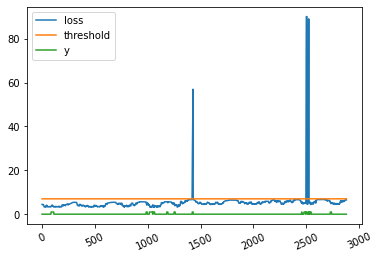

In [98]:
THRESHOLD =7


test_score_df = pd.DataFrame(index=range(len(losses)))
test_score_df['loss'] = [loss.item()/60 for loss in losses]
test_score_df['y'] = y_test_per_window
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
#test_score_df['t'] = [x[59].item() for x in sequences]

plt.plot( test_score_df.loss, label='loss')
plt.plot( test_score_df.threshold, label='threshold')
plt.plot( test_score_df.y, label='y')
plt.xticks(rotation=25)
plt.legend();

In [99]:
import numpy as np
actual,predicted=improve_detection(test_score_df)

In [100]:

from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

predicted = np.array(predicted)
actual = np.array(actual)

print_scores(predicted,actual)

True Positive	 29
True Negative	 2699
False Positive	 3
False Negative	 149
Accuracy	 0.9472222222222222
Precision	 0.90625
Recall	 0.16292134831460675
f-measure	 0.2761904761904762
cohen_kappa_score	 0.2622950819672131
auc	 0.5809055298197757
roc_auc	 0.5809055298197757
